In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
import sys
BASE_PATH = os.path.join(
   '/home/tzhouaq/ManGO_MOO/'
)
sys.path.append(BASE_PATH)
sys.path.append(os.path.join(BASE_PATH, 'off_moo_baselines'))
import logging
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd 
import datetime 
import json 
import copy
import wandb
CONDITIONAL_TASKS = []
 
import off_moo_bench as ob
from mango_utliz import save_uncon_results, plot_scatter, plot_line,  save_indicators, get_best_result, get_device
from end2end_diffusion.SDE import DiffusionMOO
from utils import set_seed
from off_moo_baselines.end2end.nets import End2EndMultiHeadModel
from off_moo_baselines.end2end.trainer import get_trainer
from off_moo_baselines.end2end.surrogate_problem import End2EndSurrogateProblem
from off_moo_baselines.data import tkwargs, get_dataloader
from off_moo_bench.task_set import *
 

Auto Configuration Succeed!, Using database /home/tzhouaq/ManGO_MOO/off_moo_bench/problem/mo_nas/database.
Configuration Succeed!
Auto Configuration Succeed!, Using database /home/tzhouaq/ManGO_MOO/off_moo_bench/problem/mo_nas/database.


/home/tzhouaq/anaconda3/envs/mango4moo/lib/python3.8/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


/home/tzhouaq/ManGO_MOO/off_moo_bench/problem/lambo/data/experiments/test/regex_problem.pkl


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
from utils import process_args 
sys.argv = ['--model=End2End', '--train_mode=Vallina','--task=zdt3','--use_wandb=False','--n_epochs=10','--retrain_model=False','--seed=1000']
config = process_args(return_dict=True)

results_dir = os.path.join('/home/tzhouaq/ManGO_MOO/', "results")
model_save_dir = os.path.join('/home/tzhouaq/ManGO_MOO/', "model")
 
config["results_dir"] = results_dir
config["model_save_dir"] = model_save_dir
config["data_pruning"] = True
config['data_preserved_ratio']= 1.0
config['hidden_size']=2048
config['inverse_lr']=1e-4
# config['batch_size']= 16
config['inverse_lr_decay']=0.98
config['n_epochs']= 200

config['simple_clip']=True
config['debais']=True
config["record_hist"]=False
config['dropout']=0. 
config['augment']=True
config['condition_training']=False
config['model_ckpt'] = None 
# config['normalize_xs'] = False
# config['normalize_ys'] = False

All config: {'results_dir': './results', 'model_save_dir': './model', 'use_wandb': False, 'run_type': 'train', 'seed': 1000, 'retrain_model': False, 'num_solutions': 256, 'solver_n_gen': 50, 'solver_init_method': 'nds', 'model': 'End2End', 'train_mode': 'Vallina', 'task': 'zdt3', 'n_epochs': 10, 'data_pruning': False, 'batch_size': 128, 'forward_lr': 0.001, 'forward_lr_decay': 0.98, 'normalize_xs': True, 'normalize_ys': True, 'to_logits': False, 'record_hist': True}


In [3]:
# initialise task
if config["task"] in ALLTASKSDICT.keys():
    config["task"] = ALLTASKSDICT[config["task"]]
results_dir = os.path.join(config['results_dir'], 
                            f"{config['model']}-{config['train_mode']}-{config['task']}")
config["results_dir"] = results_dir 

ts = datetime.datetime.utcnow() + datetime.timedelta(hours=+8)
ts_name = f"-ts-{ts.year}-{ts.month}-{ts.day}_{ts.hour}-{ts.minute}-{ts.second}"
run_name = f"Ours-{config['model']}-{config['train_mode']}-seed{config['seed']}-{config['task']}"

logging_dir = os.path.join(config['results_dir'], run_name + ts_name)
os.makedirs(logging_dir, exist_ok=True)

if config['use_wandb']:
    if 'wandb_api' in config.keys():
        wandb.login(key=config['wandb_api'])

    wandb.init(
        project="ManGO_MOO",
        name=run_name + ts_name,
        config=config,
        group=f"{config['model']}-{config['train_mode']}",
        job_type=config['run_type'],
        mode="online",
        dir=os.path.join(config['results_dir'], '..')
    )

with open(os.path.join(logging_dir, "params.json"), "w") as f:
    json.dump(config, f, indent=4)

set_seed(config['seed'])
os.environ["SEED"] = f"{config['seed']}"

task = ob.make(config['task'])
x_min, x_max, y_min, y_max = task.dataset.get_xy_min_max()
x_lbound = x_min#task.problem.xl
x_ubound = x_max#task.problem.xu
print('x_min:', x_min, '\n', 'x_max:',x_max, '\n','y_min:',y_min,'\n', 'y_max:',y_max)
print('x_lbound:', x_lbound, '\n', 'x_ubound:',x_ubound)


x_min: [1.46877364e-07 3.23648743e-05 9.02272976e-06 2.20591211e-05
 2.35930135e-05 2.19774174e-05 4.38044111e-05 2.98662293e-06
 2.96799591e-05 1.94341563e-07 1.28697638e-06 8.98145703e-06
 3.02314116e-05 3.30397804e-05 1.85274018e-05 1.55137995e-05
 8.86580017e-05 6.73842491e-06 2.74326351e-06 5.22680396e-05
 7.71740746e-06 6.58762017e-06 4.13200157e-06 7.23183858e-07
 1.46763941e-05 2.17749820e-05 5.81122823e-05 6.15200866e-05
 1.59228351e-05 2.70804370e-05] 
 x_max: [0.99999894 0.99999979 0.99998133 0.99999975 0.99999779 0.99999488
 0.99997792 0.99997588 0.99992981 0.99999675 0.99999534 0.99999858
 0.99984315 0.99999593 0.99998894 0.99995769 0.99997698 0.99999878
 0.99998792 0.99999209 0.99998981 0.99999674 0.99998515 0.99992605
 0.99996657 0.99996406 0.99989975 0.99975005 0.99996973 0.99997179] 
 y_min: [ 0.         -0.77336901] 
 y_max: [0.99999894 7.90000139]
x_lbound: [1.46877364e-07 3.23648743e-05 9.02272976e-06 2.20591211e-05
 2.35930135e-05 2.19774174e-05 4.38044111e-05 2.98

In [4]:
#There are some issues with the normalization implemented by benchmark. Here, let's avoid them to obtaine X and Y directly.
X = task.x.copy()
y = task.y.copy()
 
X_test = copy.deepcopy(task.x_test)
y_test = copy.deepcopy(task.y_test)

len_data = task.x.shape[0]
if config["data_pruning"]:
    X, y = task.get_N_non_dominated_solutions(
        N=int(len_data * config["data_preserved_ratio"]),
        return_x=True, return_y=True
    )

if config['to_logits']:
    assert task.is_discrete 
    task.map_to_logits()
    X = task.to_logits(X)
    X_test = task.to_logits(X_test)
if config['normalize_xs']:
    task.map_normalize_x()
    # X = copy.deepcopy(X)
    X = task.normalize_x(X)
    X_test = task.normalize_x(X_test)
    x_lbound = task.normalize_x(x_lbound)
    x_ubound = task.normalize_x(x_ubound)
    x_min = task.normalize_x(x_min)
    x_max = task.normalize_x(x_max)
pf = task.problem.get_pareto_front() 
if config['normalize_ys']:
    task.map_normalize_y()
    y = task.normalize_y(y)
    y_test = task.normalize_y(y_test)
    pf = task.normalize_y(pf)
    y_min = task.normalize_y(y_min)
    y_max = task.normalize_y(y_max)

if config['to_logits']:
    data_size, n_dim, n_classes = tuple(X.shape)
    X = X.reshape(-1, n_dim * n_classes)
    X_test = X_test.reshape(-1, n_dim * n_classes)
else:
    data_size, n_dim = tuple(X.shape)
n_obj = y.shape[1]

X.shape, y.shape, X_test.shape, y_test.shape


((60000, 30), (60000, 2), (40000, 30), (40000, 2))

In [5]:
#This cell is to train or load the forward model
config['retrain_model']=False
config['n_epochs']= 200
config['batch_size']= 32
config["train_mode"] = "gradnorm"
config["gradient_alpha"] = 0.12
model_save_dir = config['model_save_dir']
config["weight_lr"] = 5e-4
config['weight_lr_decay']=0.99
model_save_dir = config['model_save_dir']
os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(
    model_save_dir,
    f"{config['model']}-{config['train_mode']}-{config['task']}-{config['seed']}.pt"
)
model = End2EndMultiHeadModel(
    n_dim=n_dim * n_classes if config['to_logits'] else n_dim,
    n_obj=n_obj,
    hidden_size=[2048, 2048],
    save_path=model_save_path,
).to(**tkwargs)

trainer_func = get_trainer(config["train_mode"])

trainer = trainer_func(
    forward_model=model, 
    config=config
)

(
    train_loader,
    val_loader,
    test_loader
) = get_dataloader(X, y, X_test, y_test,
                    val_ratio=0.01,
                    batch_size=config["batch_size"])

trainer.launch(
    train_loader,
    val_loader,
    test_loader,
    retrain_model=config["retrain_model"]
)


#attain the surrogate problem
surrogate_problem = End2EndSurrogateProblem(
    n_var=n_dim * n_classes if config['to_logits'] else n_dim, n_obj=n_obj, model=model
)


Successfully load trained model from /home/tzhouaq/ManGO_MOO/model/End2End-gradnorm-ZDT3-Exact-v0-1000.pt with valid MSE = 0.0011293282732367516


In [6]:
from end2end_diffusion.mango_training import mango_train

print(config['inverse_lr'])
CONDITIONAL_TASKS = []
if config['augment']:

    clip_min = torch.tensor(np.concatenate((x_lbound, y_min)))
    clip_max = torch.tensor(np.concatenate((x_ubound, y_max)))
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)

clip_dic = {'simple_clip': config['simple_clip'], 'clip_min': clip_min , 'clip_max': clip_max}
print(clip_dic)

try:
    inverse_model
except NameError:
    inverse_model = None

# inverse_model = None
# config['n_epochs']=400
# # # # # clip_dic['simple_clip']=True
# inverse_model = mango_train(
#     task=task,
#     X=X,
#     y=y,
#     forward_model=model,
#     inverse_model=inverse_model,
#     hidden_size=config['hidden_size'],
#     lr=config['inverse_lr'],
#     dropout=config['dropout'],
#     device='auto',
#     seed=config['seed'],
#     num_epochs= config['n_epochs'],
#     ckpt_dir=config['model_save_dir'],
#     score_matching=True,
#     # data_preserved_ratio=config['data_preserved_ratio'],  
#     clip_dic=clip_dic,
#     # debais=config['debais'],
#     augment=config['augment'],
#     condition_training=config['condition_training']
# )


0.0001
{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)}


In [7]:
# load the pretrained model
model_ckpt = '/home/tzhouaq/ManGO_MOO/model/ours-zdt3-seed1000-hidden2048-score_matchingTrue.ckpt' #e=1000, 0.2*full data

inverse_model = DiffusionMOO.load_from_checkpoint(
    model_ckpt,
    taskname=task.dataset_name,
    task=task,
    learning_rate=config['inverse_lr'],
    dropout_p=config['dropout'],
    hidden_size=config['hidden_size'],
    simple_clip=clip_dic['simple_clip'],
    clip_min= clip_dic['clip_min'],
    clip_max= clip_dic['clip_max'],
    debais=config['debais'],
    augment=config['augment'],
    forwardmodel=model,
    condition_training=False
)

uncondition_training T: {1.0}


{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)}


Hypervolume (100th): 4.988658
Ideal Hypervolume: 5.919540
L2 dist between design score and given y: 3.1312284518839957
L2 dist between generated and given y: 4.016433184495844
Best design is: 
 [0.02358398 0.43784803 0.36950973 0.31568772 0.20080964 0.41000274
 0.45624882 0.2121927  0.31544247 0.33058804 0.48736185 0.3543266
 0.33105618 0.34708193 0.27977115 0.34934852 0.4296665  0.5549774
 0.32853404 0.36492932 0.41906095 0.26657087 0.29834777 0.45798564
 0.4156725  0.5849202  0.4281559  0.30144593 0.3481735  0.47632223
 0.02289475 0.56282115]
Best design score is: 
 [0.02358401 0.55461129]
Best design score in training set: 
 [0.01774484 0.55067875]
Oracle design score is: 
 [3.85620111e-07 4.78083851e-04]
Distance between the best to oracle value in training set is :
 0.5504867244374733
Distance between the best to oracle value is :
 0.5546348344831781
Hypervolume (100th): 5.115988
Hypervolume (75th): 5.005172
Hypervolume (50th): 4.925891
Hypervolume (D(best)): 5.067155
Ideal Hyperv

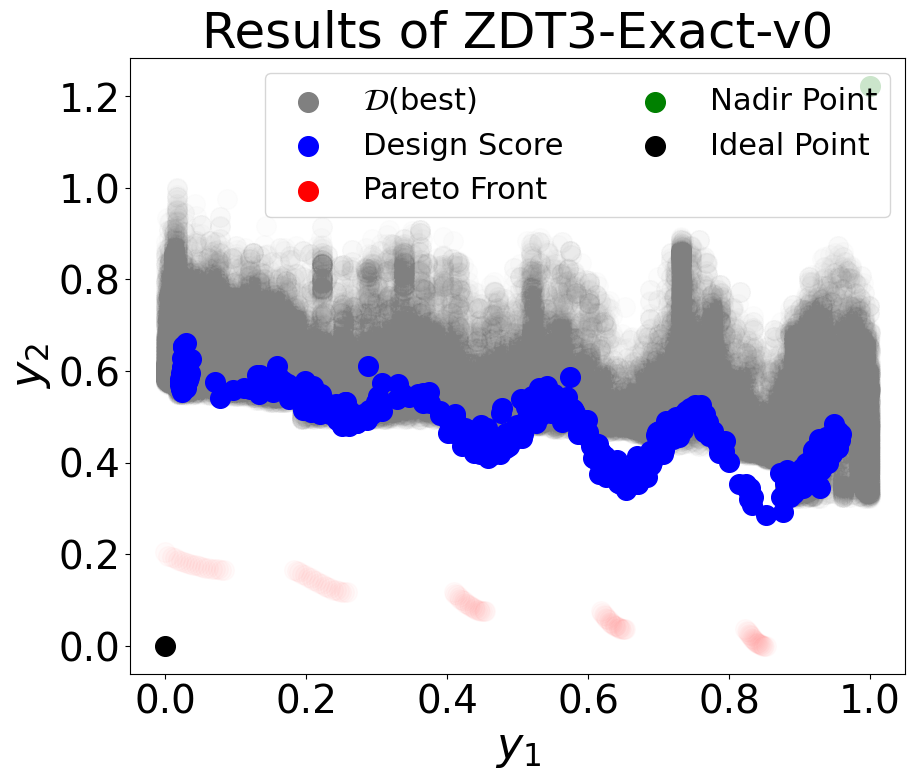

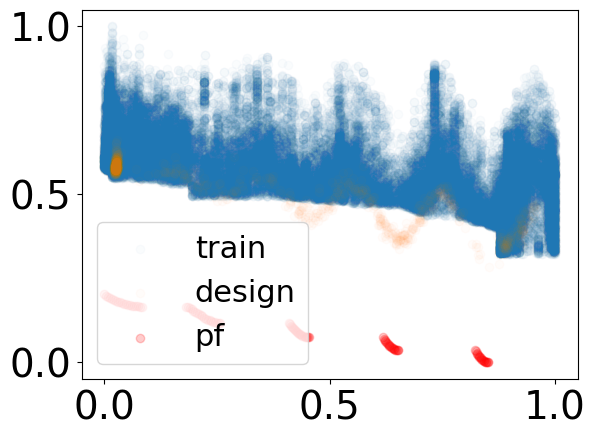

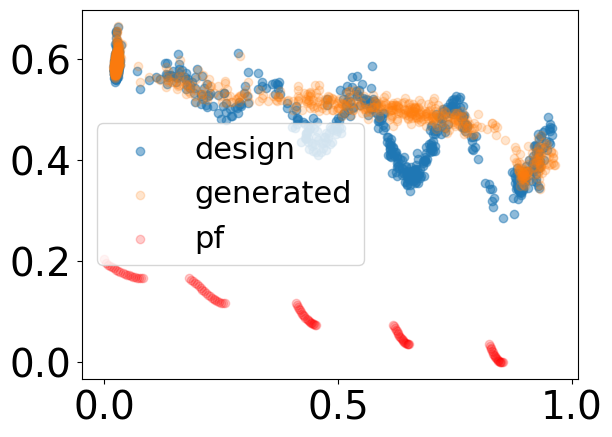

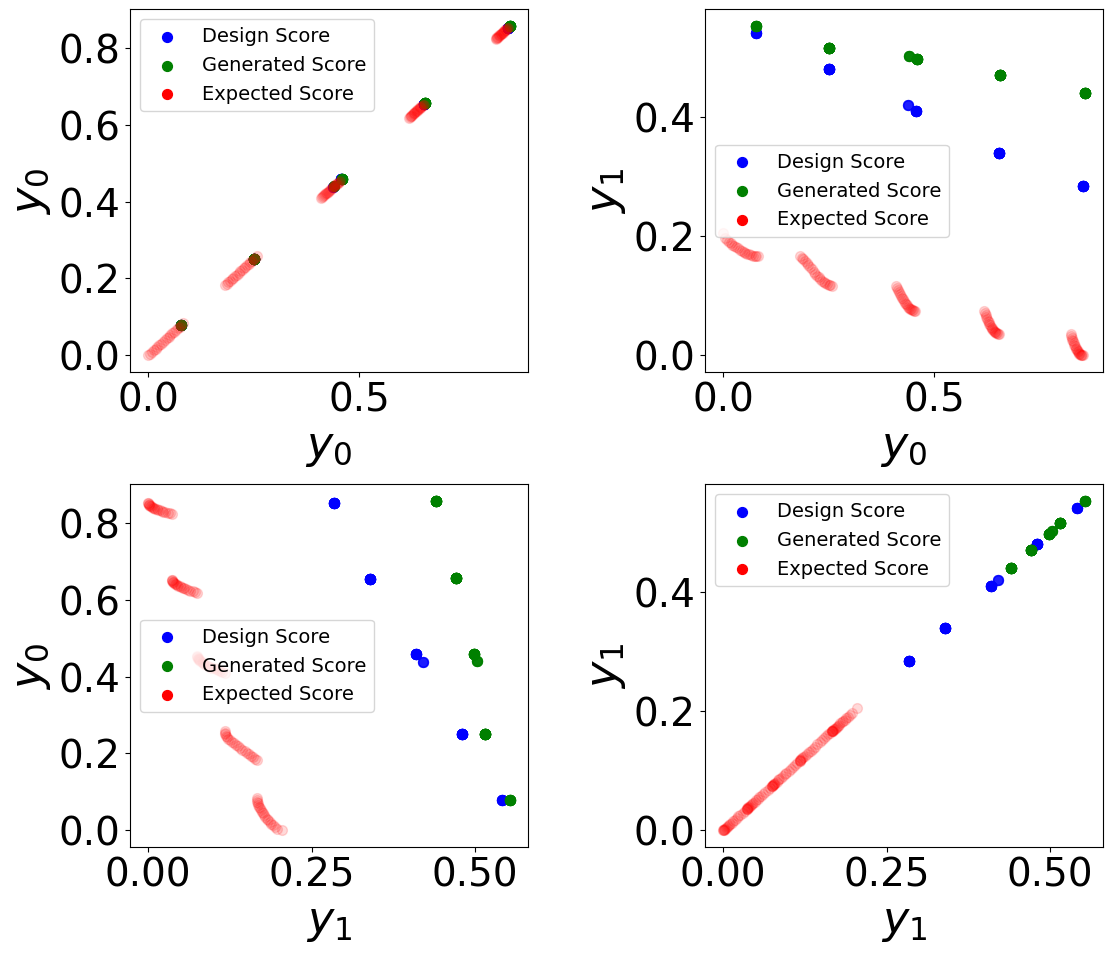

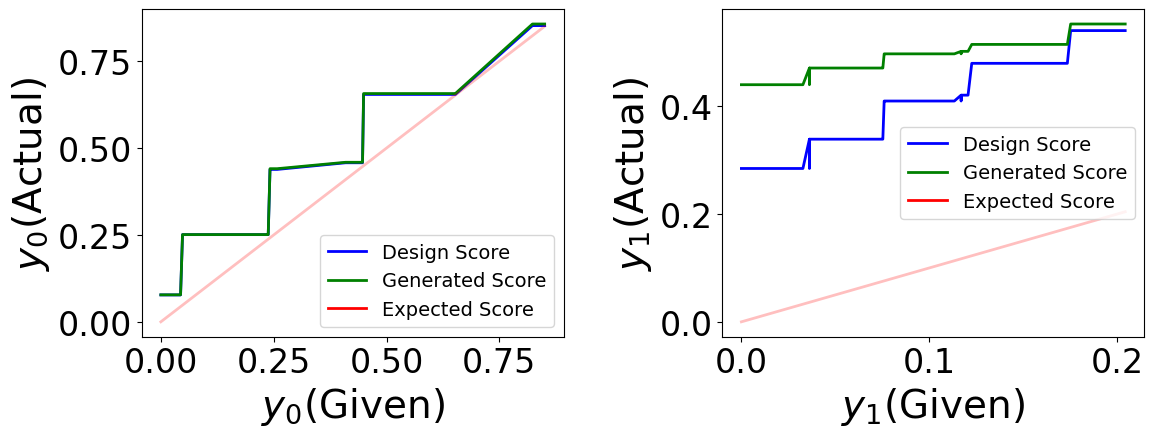

In [8]:
#This cell is to conduct unconditional generation 
from end2end_diffusion.mango_eval_fks import mango_eval, fixed_random_seed

if config['augment']:
    pf = task.problem.get_pareto_front() 
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    y_min = np.minimum(y_min, pf.min(axis=0))
    y_max = np.maximum(y_max, pf.max(axis=0))
    clip_min = torch.tensor(np.concatenate((x_min, y_min)))#x_lbound
    clip_max = torch.tensor(np.concatenate((x_max, y_max)))#x_ubound
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)
print(clip_dic)

num_samples = 1000
 
res = mango_eval(
    task=task,
    forwardmodel=model,
    inverse_model=inverse_model,
    device='auto',
    num_samples=num_samples,
    # seed=config['seed'],
    logging_dir=logging_dir,
    ckpt_dir=config['model_save_dir'],
    augment=config['augment'],
    clip_dic=clip_dic,
    condition_training=config['condition_training'],
    # gen_condition=y_given,
    num_steps=1000
    # guidance=True
)
res_x, res_y, y_cand, y_gen, y_given_list = save_uncon_results(res, task, config, model, logging_dir, X, y)

pf = task.problem.get_pareto_front()
if config['normalize_ys']:
    pf = task.normalize_y(pf)

plt.scatter(y[:,0],y[:,1],label='train',alpha=0.02)
plt.scatter(res_y[:,0],res_y[:,1],label='design',alpha=0.02)
# plt.scatter(y_test[:,0],y_test[:,1],label='test',alpha=0.02)
plt.scatter(pf[:,0],pf[:,1],label='pf',color='r',alpha=0.2)
plt.legend()
plt.show()
y_dim = task.y.shape[-1]
plt.scatter(res_y[:,0],res_y[:,1],label='design',alpha=0.5)
plt.scatter(res_x[:,-y_dim],res_x[:,-(y_dim-1)],label='generated',alpha=0.2)
plt.scatter(pf[:,0],pf[:,1],label='pf',color='r',alpha=0.2)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.legend()

#plot scatter and line
description = 'uncond'
kkk = 100
seed = 42
plot_scatter(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
plot_line(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
 

{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)}
{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)}
****************************************Seed: 40*********************************************************


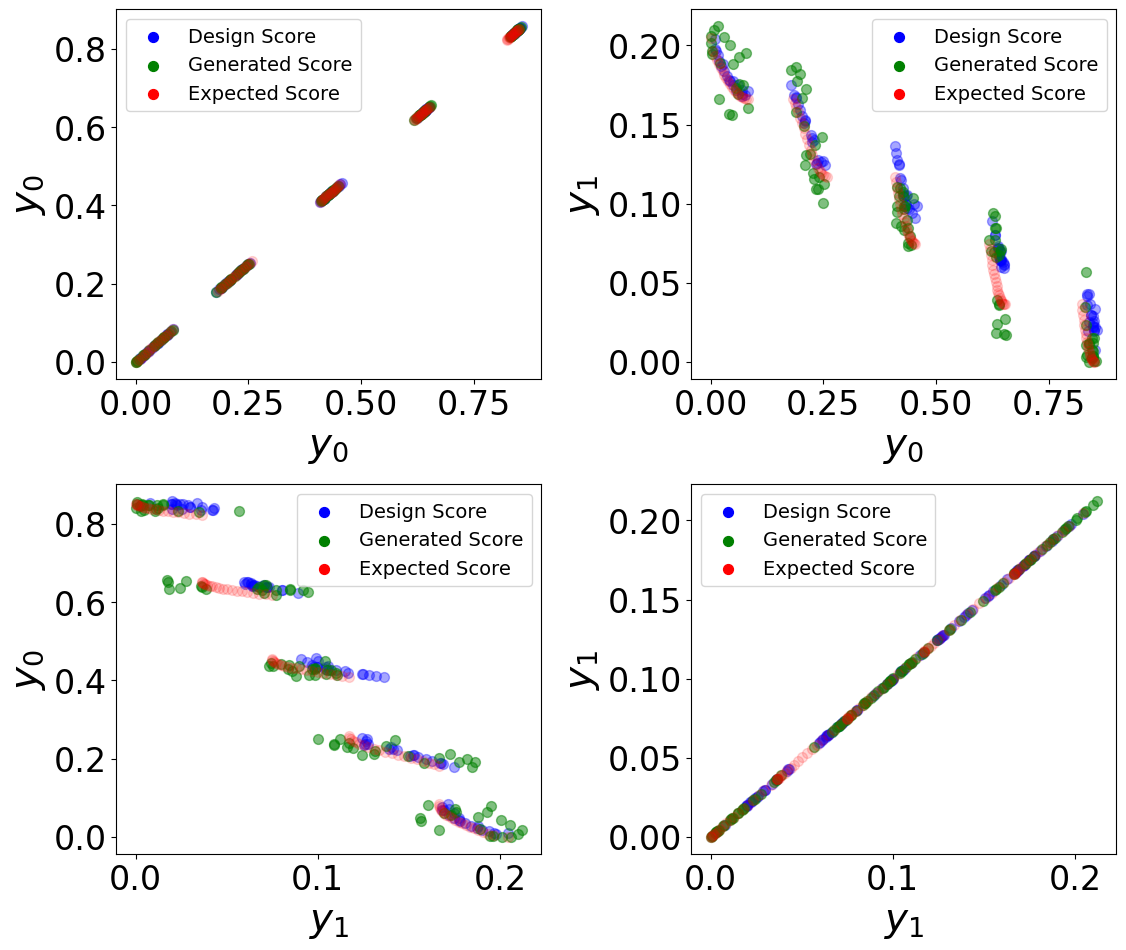

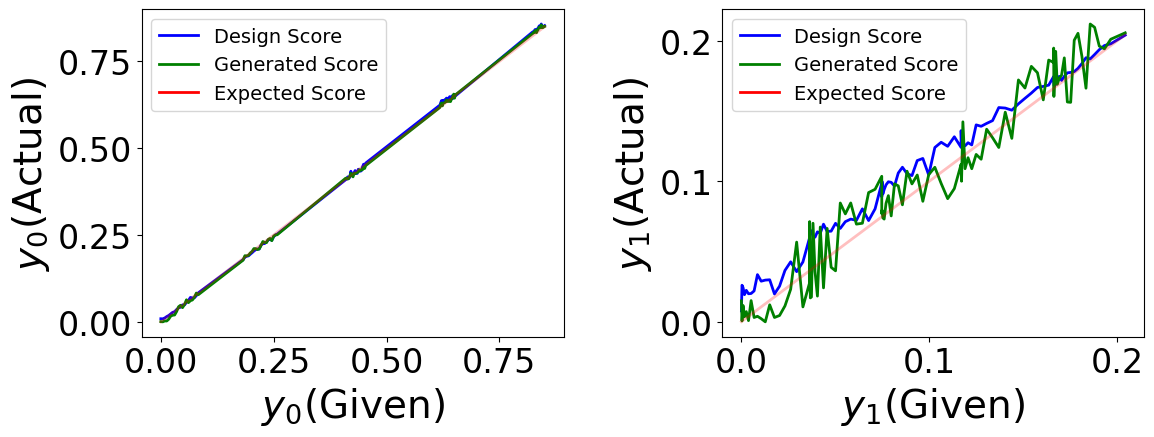

Hypervolume (100th): 5.793311
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.011075578574069454
GD+: 0.01105151332840921
IGD: 0.009820190297201716
IGD+: 0.00951835307724355
L2 dist between design score and given y: 0.1506769438936135
L2 dist between generated and given y: 0.15720419560004767
Spread for y_cand: 1.02586037470468
Spread for y_gen: 0.8206048700661174
****************************************Seed: 41*********************************************************


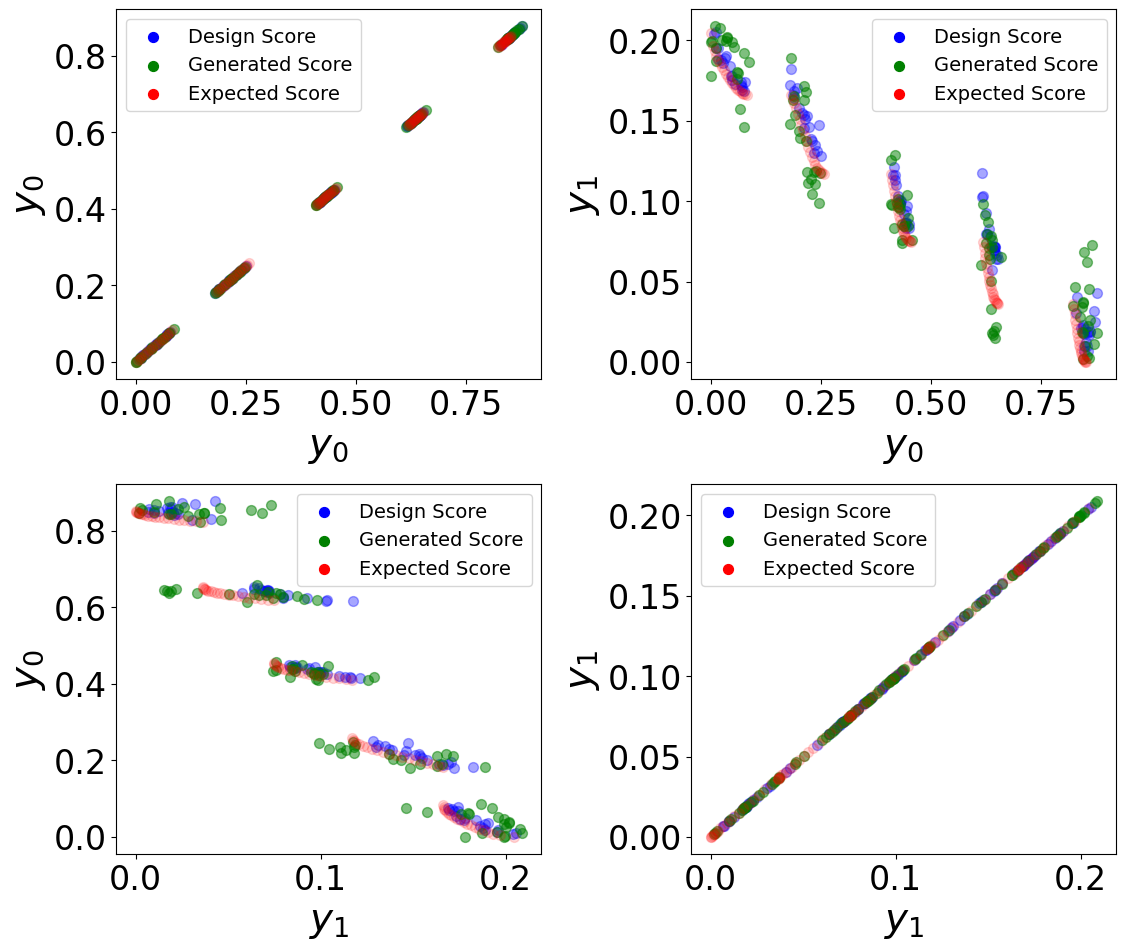

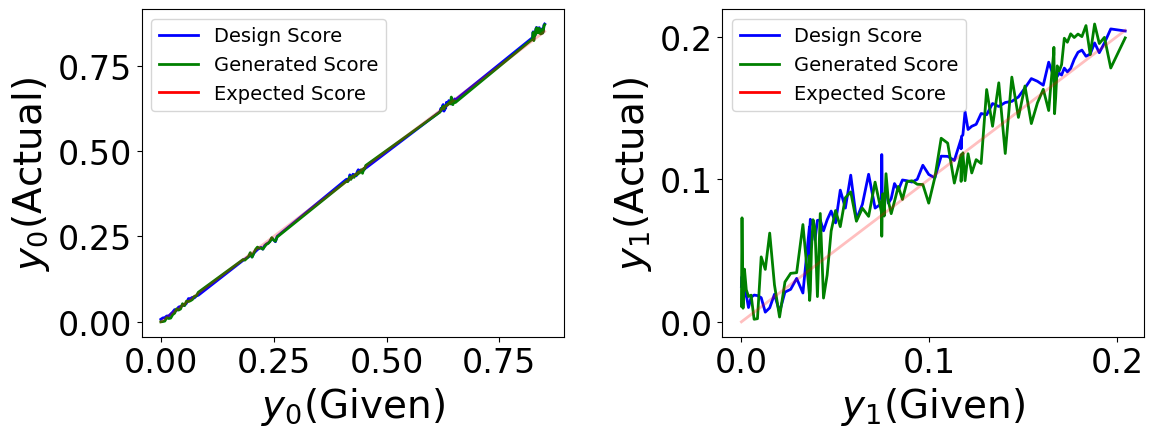

Hypervolume (100th): 5.799127
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.011600524358697892
GD+: 0.011590299464784563
IGD: 0.007986603596254001
IGD+: 0.007514014120461828
L2 dist between design score and given y: 0.16997831061318738
L2 dist between generated and given y: 0.19945872184548546
Spread for y_cand: 0.965767187774233
Spread for y_gen: 0.8586698564767552
****************************************Seed: 42*********************************************************


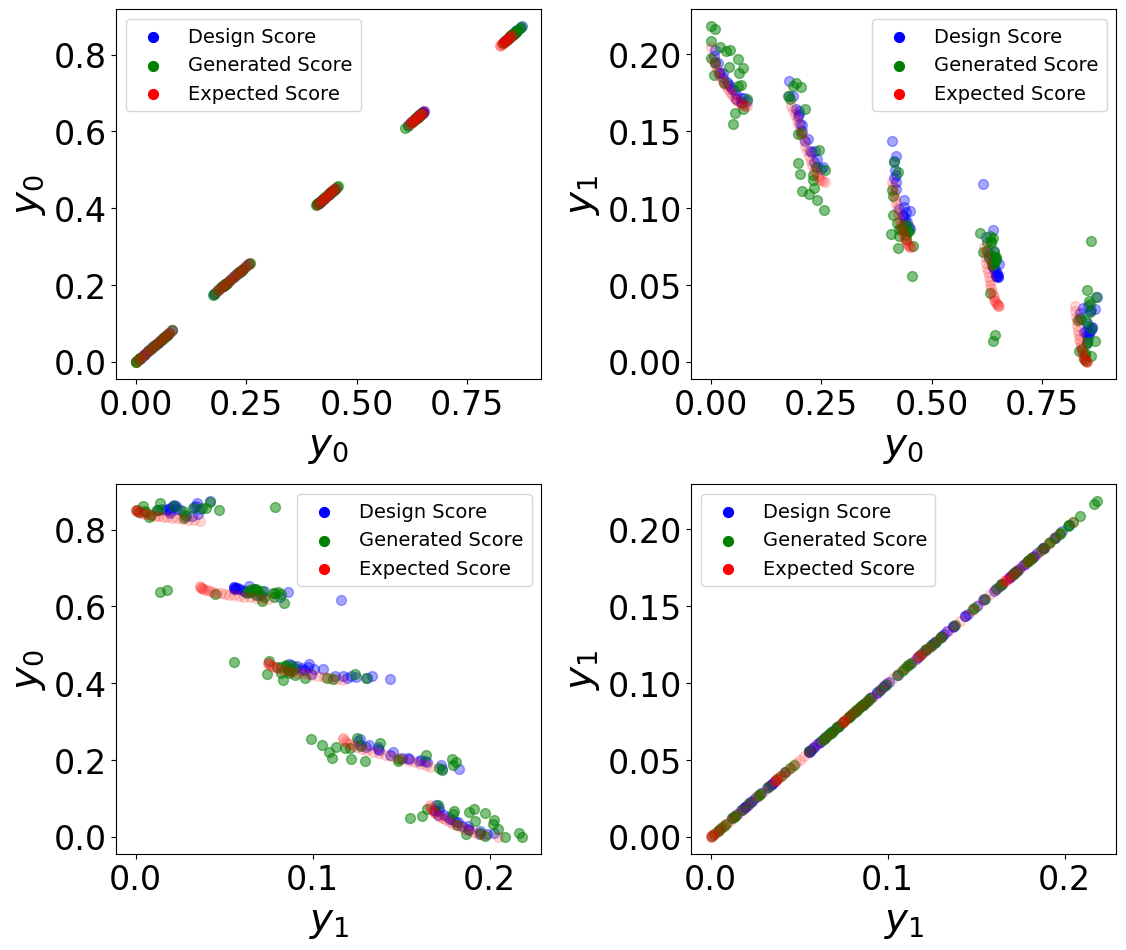

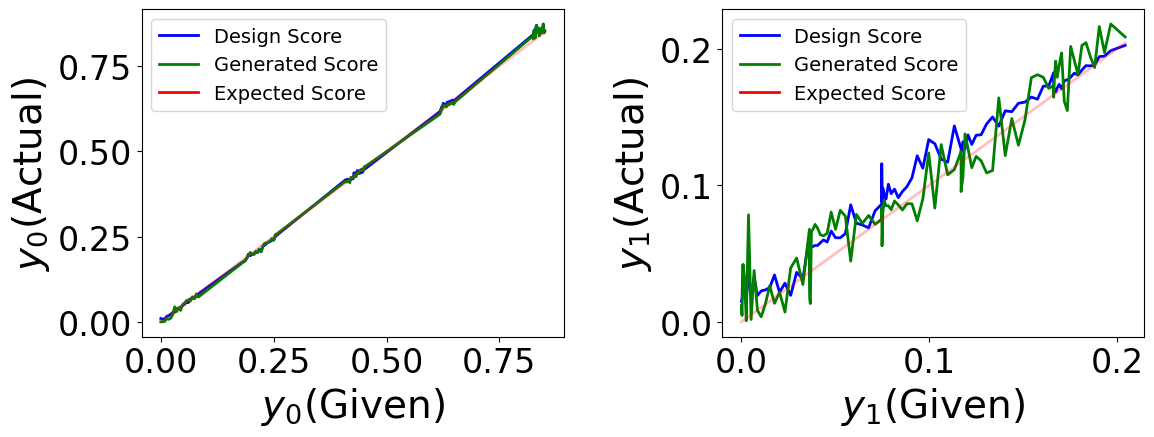

Hypervolume (100th): 5.791370
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.011925030424696274
GD+: 0.011887106833755727
IGD: 0.008391057401360168
IGD+: 0.008091907683869151
L2 dist between design score and given y: 0.15146031662345916
L2 dist between generated and given y: 0.18718864481861608
Spread for y_cand: 0.9546608324148281
Spread for y_gen: 0.8160491704248748
****************************************Seed: 43*********************************************************


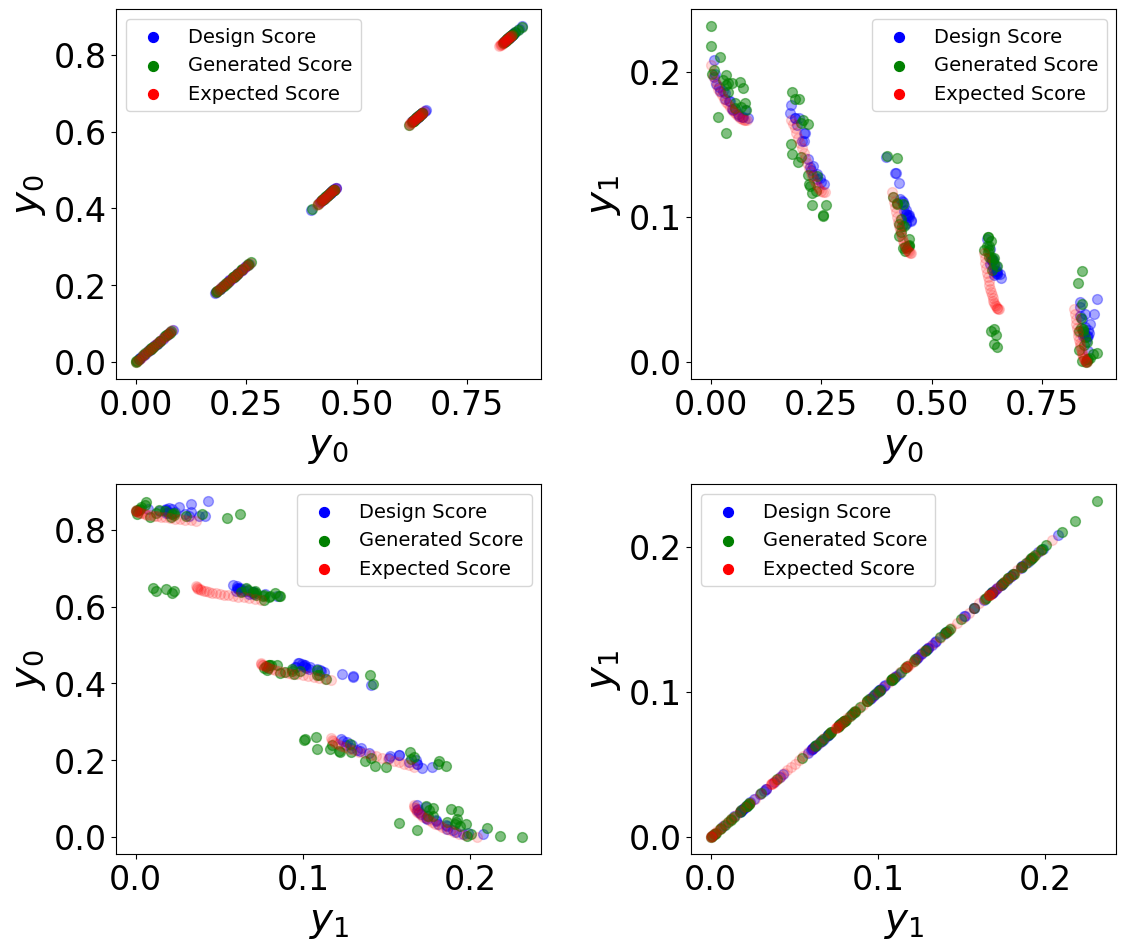

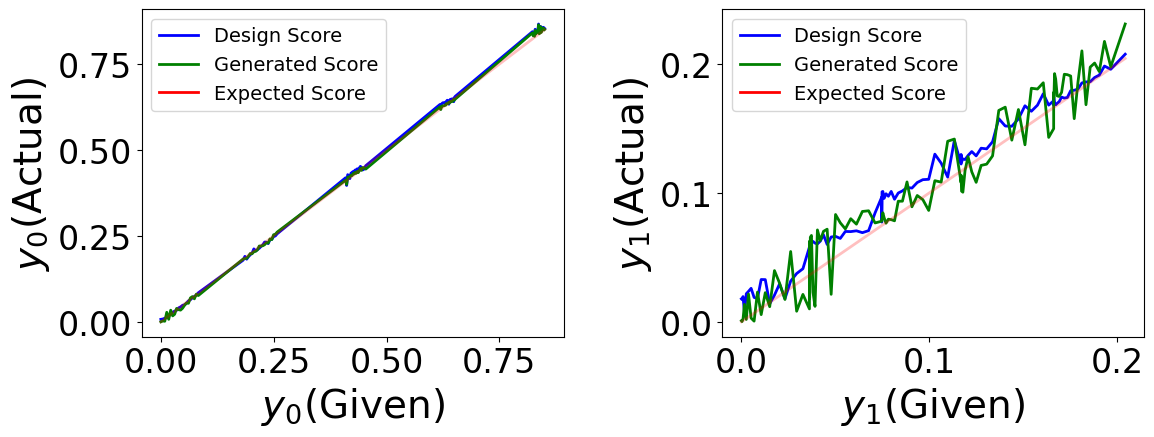

Hypervolume (100th): 5.797245
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.012178050089946171
GD+: 0.012111143093578396
IGD: 0.010105563732908168
IGD+: 0.009687519913689421
L2 dist between design score and given y: 0.15110691957310468
L2 dist between generated and given y: 0.16766917095758832
Spread for y_cand: 1.0152503309244116
Spread for y_gen: 0.8777402448420945


In [9]:
#This cell is to conduct conditional generation  with k = 256
if config['augment']:
    pf = task.problem.get_pareto_front() 
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    y_min = np.minimum(y_min, pf.min(axis=0))
    y_max = np.maximum(y_max, pf.max(axis=0))
    clip_min = torch.tensor(np.concatenate((x_min, y_min)))#x_lbound
    clip_max = torch.tensor(np.concatenate((x_max, y_max)))#x_ubound
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)
print(clip_dic)

config['simple_clip'] = True
# clip_min = - torch.ones_like(clip_min)*0.1
clip_dic = {'simple_clip': config['simple_clip'], 'clip_min': clip_min , 'clip_max': clip_max}
print(clip_dic)

# y_given_list  = np.linspace(0.1, 15, 100)
with fixed_random_seed(1000):
    if len(pf)<1000:
        rand_idx = list(range(len(pf)))
    else:
        rand_idx = np.random.choice(len(pf), 1000, replace=False)
y_given_list =  pf[rand_idx]
num_samples = 1000

num_steps = 200
inference_scaling_bool = True
duplicated_time = 64
description = 'resampling_fks'
kkk=256

seed_list = [40, 41, 42, 43]
HV_list = []
IGD_list = []

import pickle

for seed in seed_list:
    print(f"****************************************Seed: {seed}*********************************************************")
    xy_pred = {f'{n}': None for n in range(num_samples)}
    xy_scores = {f'{n}': None for n in range(num_samples)}

    all_res = {"y_given_list":y_given_list}
    all_res['denoising_step'] = num_steps
    all_res['inference_scaling_bool'] = inference_scaling_bool
    all_res['duplicated_time'] = duplicated_time
    all_res['shot_num'] = kkk 
    all_res.update(clip_dic)

    for i in y_given_list:
        y_given = torch.tensor(i) 
        res = mango_eval(
            task=task,
            forwardmodel=model,
            inverse_model=inverse_model,
            # hidden_size=config['hidden_size'],
            device='auto',
            num_samples= config['num_solutions'],
            seed=seed,
            logging_dir=logging_dir,
            ckpt_dir=config['model_save_dir'],
            augment=config['augment'],
            clip_dic=clip_dic,
            gamma=0,
            gen_condition=y_given,
            guidance=True,
            num_steps=num_steps,
            inference_scaling_bool=inference_scaling_bool,
            duplicated_time=duplicated_time,
        )
        for num_samples1 in range(res['x'].shape[0]):
            if xy_pred[f'{num_samples1}'] is None:
                xy_pred[f'{num_samples1}'] = res['x'][num_samples1]
                # xy_scores[f'{num_samples}'] = res['y_scores'][num_samples]
            else:
                xy_pred[f'{num_samples1}'] = np.vstack((xy_pred[f'{num_samples1}'], res['x'][num_samples1]))
                # xy_scores[f'{num_samples}'] = np.vstack((xy_scores[f'{num_samples}'], res['y_scores'][num_samples]))

        all_res[f'y_given_{i}'] = res

    #save all_res
    file_path = os.path.join(logging_dir, f"cond_{description}_all_res_shot{kkk}_seed{seed}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(all_res, f)

    #get best result
    x_opt_cand, y_cand, y_gen, valid_num = get_best_result(task, res, xy_pred, y_given_list, clip_max, clip_min, kkk, config)

    np.save(f'{logging_dir}/cond_{description}_res_x_opt_cand_shot{kkk}_seed{seed}.npy', x_opt_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_cand_shot{kkk}_seed{seed}.npy', y_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_gen_shot{kkk}_seed{seed}.npy', y_gen)
 

    #plot scatterr
    plot_scatter(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #plot line
    plot_line(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #save indicators
    save_indicators(HV_list, IGD_list, y_cand, y_gen, y_given_list, pf, description, logging_dir, kkk, seed, config, task)

In [10]:
print(f"Average Hypervolume: {np.mean(HV_list):.4f} ± {np.std(HV_list):.4f}")
print(f"Average IGD: {np.mean(IGD_list):.4f} ± {np.std(IGD_list):.4f}")

Average Hypervolume: 5.7953 ± 0.0031
Average IGD: 0.0091 ± 0.0009


{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)}
{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)}
****************************************Seed: 40*********************************************************


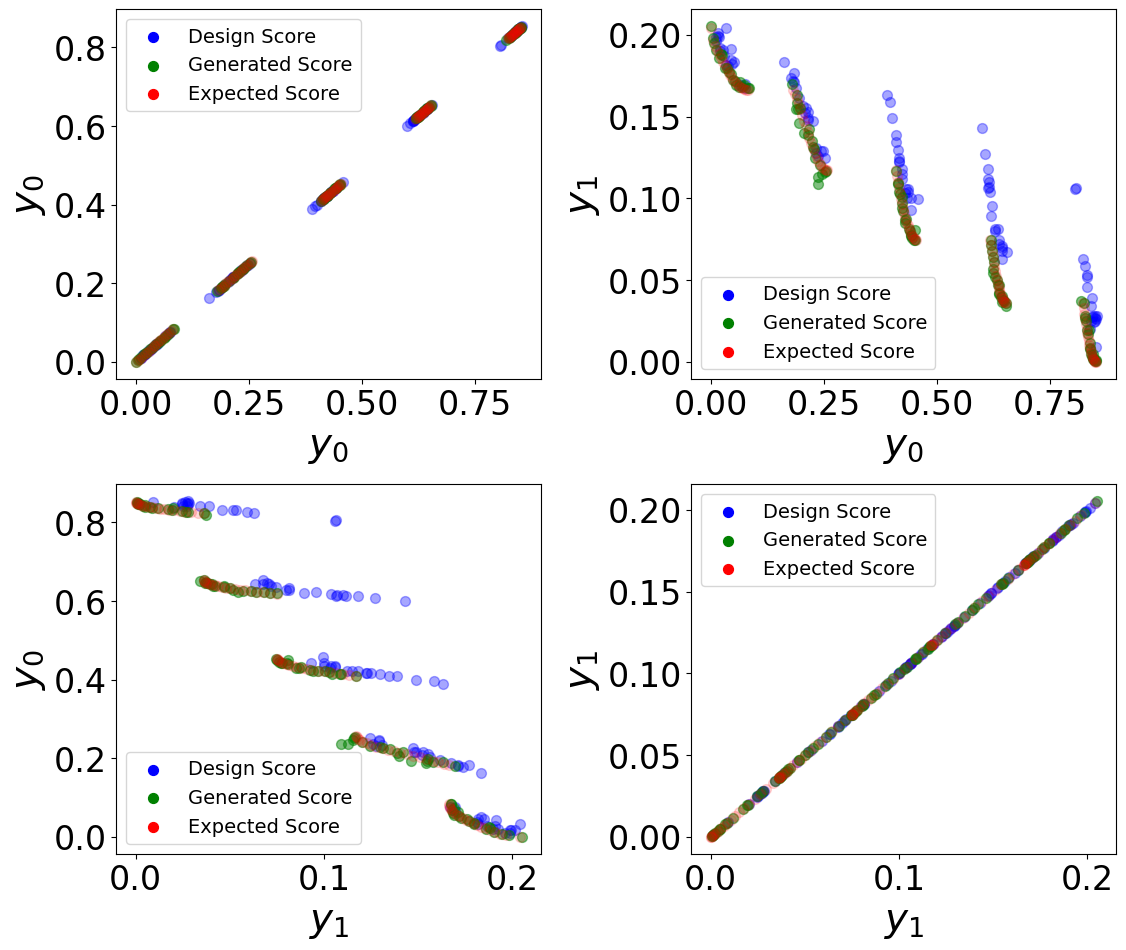

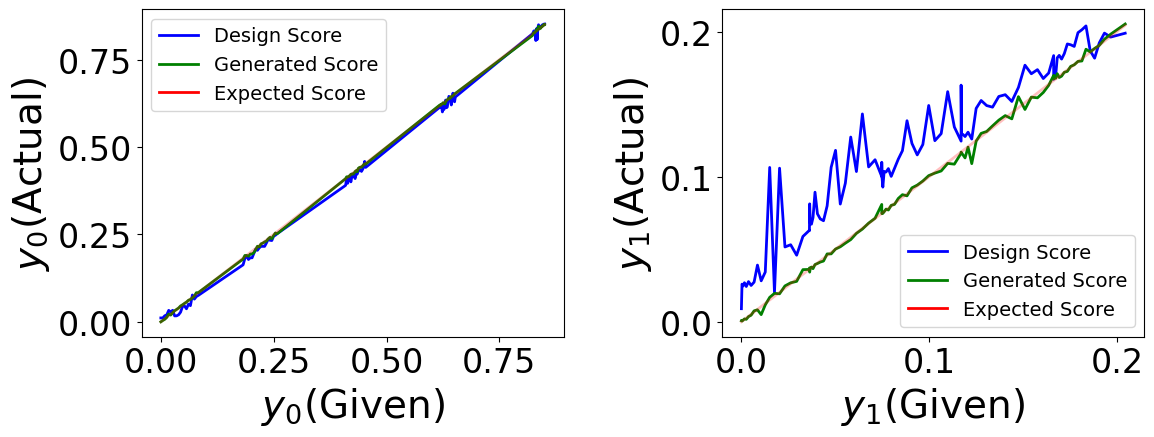

Hypervolume (100th): 5.784097
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.0165222338357391
GD+: 0.0162366078257654
IGD: 0.01094349881886839
IGD+: 0.010446880448951949
L2 dist between design score and given y: 0.3144092219093749
L2 dist between generated and given y: 0.026740086914371713
Spread for y_cand: 0.959223149986996
Spread for y_gen: 1.0206636323986702
****************************************Seed: 41*********************************************************


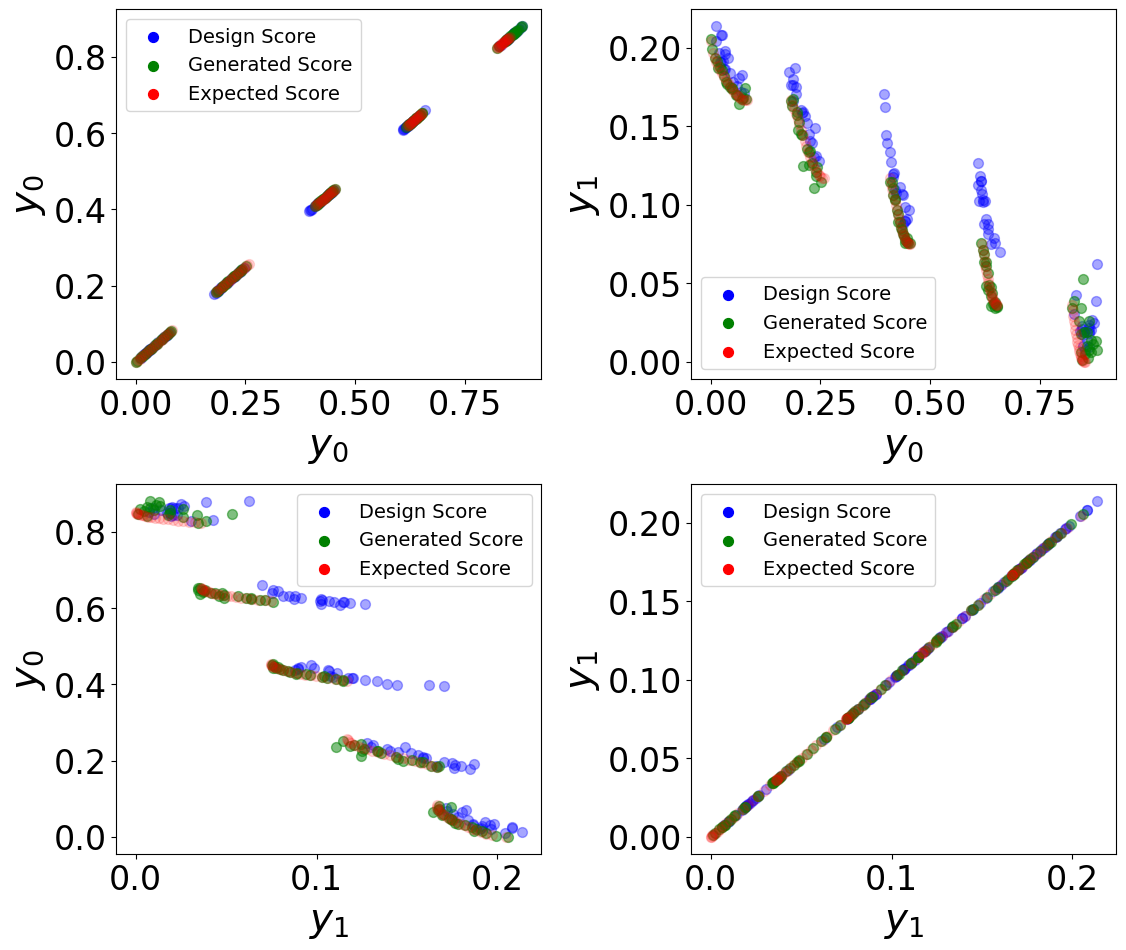

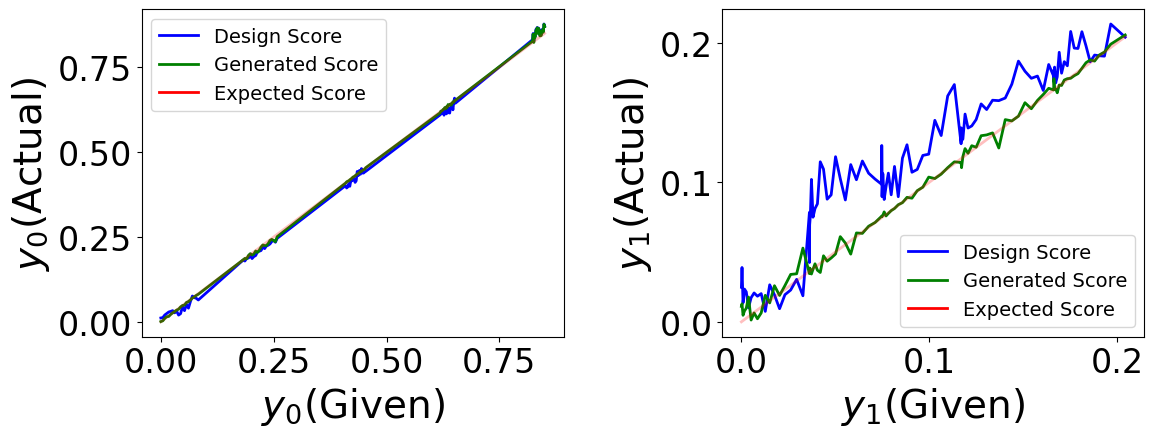

Hypervolume (100th): 5.784250
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.017586443968334118
GD+: 0.01748403104173528
IGD: 0.011953538995902178
IGD+: 0.011539781987842904
L2 dist between design score and given y: 0.3024352675589196
L2 dist between generated and given y: 0.09406015030474976
Spread for y_cand: 0.8814994333704703
Spread for y_gen: 0.9768360417100498
****************************************Seed: 42*********************************************************


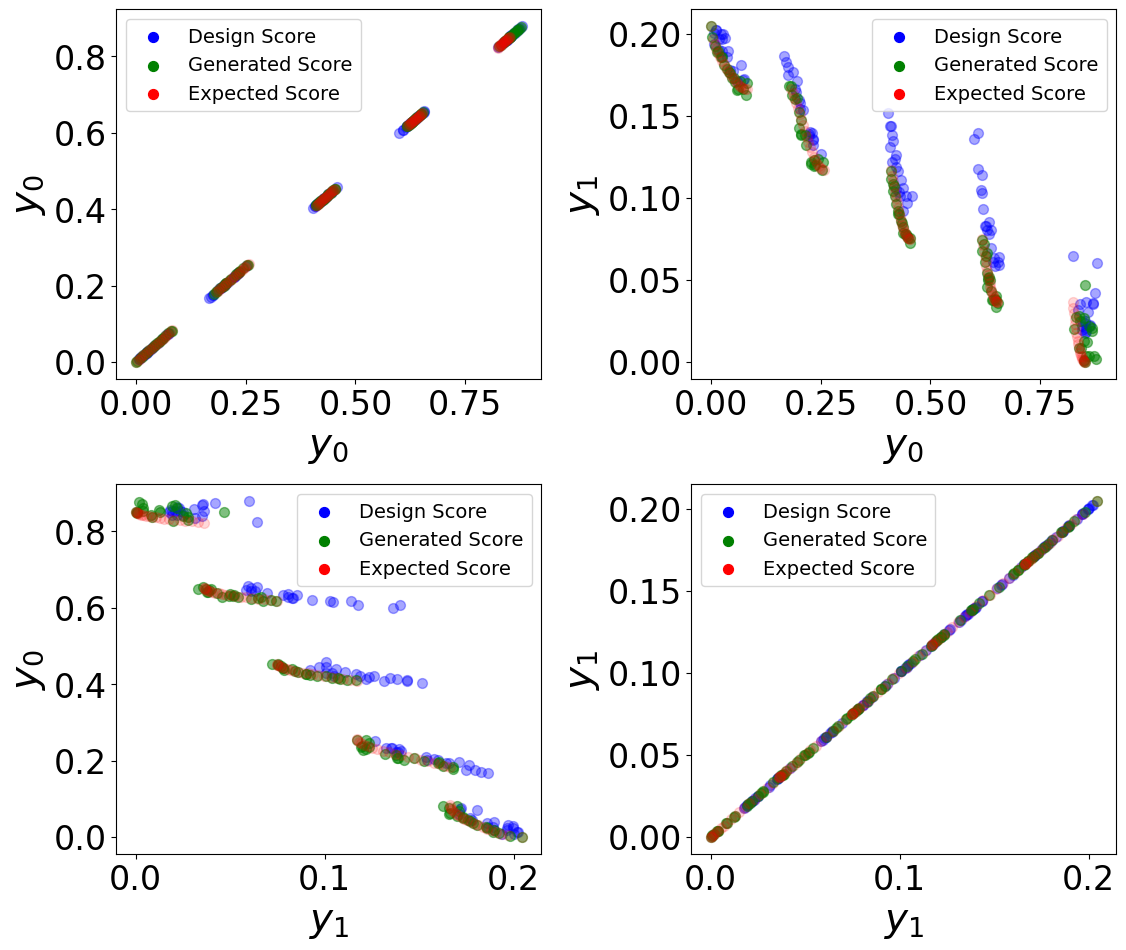

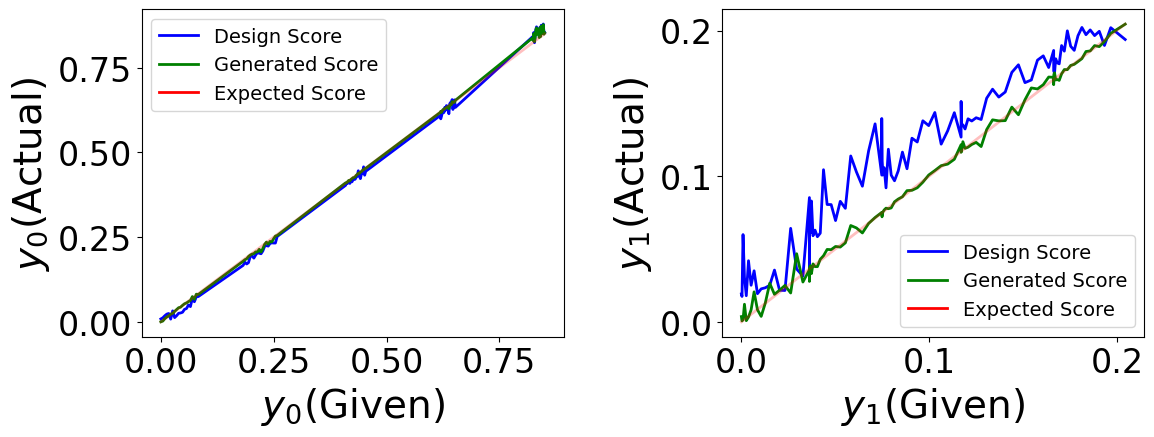

Hypervolume (100th): 5.780890
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.01665279154685917
GD+: 0.016446244077244255
IGD: 0.010872104196196797
IGD+: 0.010299665111403638
L2 dist between design score and given y: 0.269629996559304
L2 dist between generated and given y: 0.08958655411307649
Spread for y_cand: 0.9027904106746855
Spread for y_gen: 0.9956164966671266
****************************************Seed: 43*********************************************************


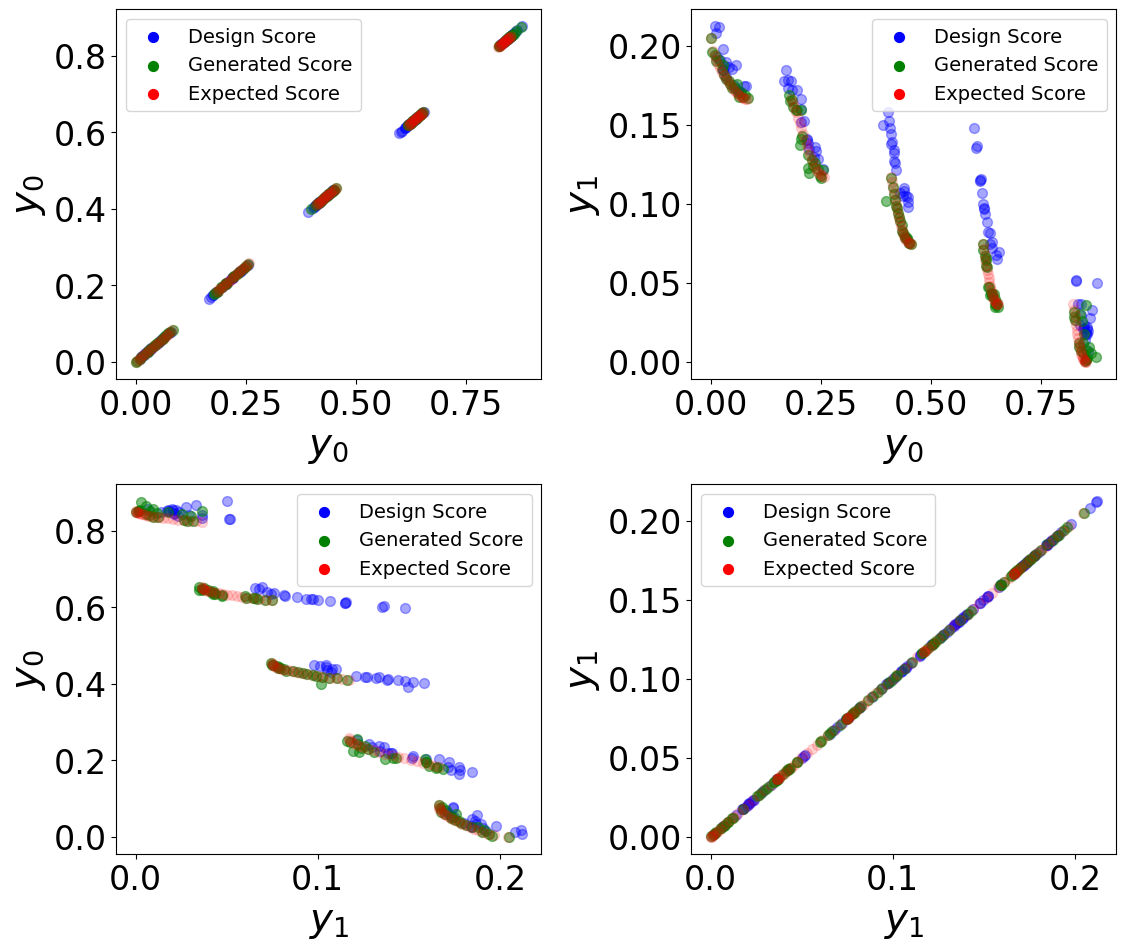

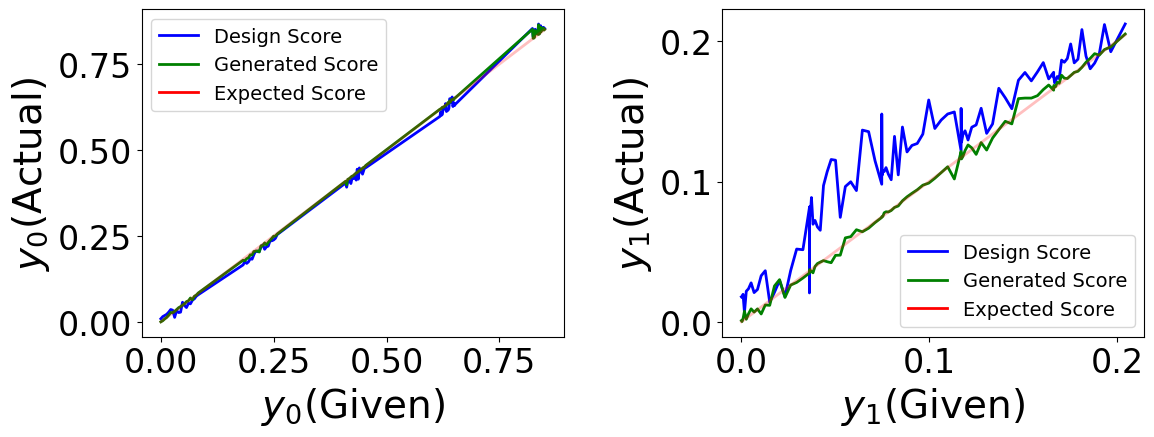

Hypervolume (100th): 5.791351
Hypervolume (D(best)): 0.879814
Ideal Hypervolume: 5.919540
y_given Hypervolume: 5.836247
pf Hypervolume: 5.836247
GD: 0.017505003060845556
GD+: 0.01719356385292629
IGD: 0.012319386342746215
IGD+: 0.011855239973101664
L2 dist between design score and given y: 0.3129647763706762
L2 dist between generated and given y: 0.0648824893212376
Spread for y_cand: 0.9380447657657545
Spread for y_gen: 1.0202774566889463


In [11]:
#This cell is to conduct conditional generation  with k = 1
if config['augment']:
    pf = task.problem.get_pareto_front() 
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    y_min = np.minimum(y_min, pf.min(axis=0))
    y_max = np.maximum(y_max, pf.max(axis=0))
    clip_min = torch.tensor(np.concatenate((x_min, y_min)))#x_lbound
    clip_max = torch.tensor(np.concatenate((x_max, y_max)))#x_ubound
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)
print(clip_dic)

config['simple_clip'] = True
# clip_min = - torch.ones_like(clip_min)*0.1
clip_dic = {'simple_clip': config['simple_clip'], 'clip_min': clip_min , 'clip_max': clip_max}
print(clip_dic)

# y_given_list  = np.linspace(0.1, 15, 100)
with fixed_random_seed(1000):
    if len(pf)<1000:
        rand_idx = list(range(len(pf)))
    else:
        rand_idx = np.random.choice(len(pf), 1000, replace=False)
y_given_list =  pf[rand_idx]
num_samples = 1000

num_steps = 200
inference_scaling_bool = True
duplicated_time = 64
description = 'resampling_fks'
kkk=1

seed_list = [40, 41, 42, 43]
HV_list = []
IGD_list = []

import pickle

for seed in seed_list:
    print(f"****************************************Seed: {seed}*********************************************************")
    xy_pred = {f'{n}': None for n in range(num_samples)}
    xy_scores = {f'{n}': None for n in range(num_samples)}

    all_res = {"y_given_list":y_given_list}
    all_res['denoising_step'] = num_steps
    all_res['inference_scaling_bool'] = inference_scaling_bool
    all_res['duplicated_time'] = duplicated_time
    all_res['shot_num'] = kkk 
    all_res.update(clip_dic)

    for i in y_given_list:
        y_given = torch.tensor(i) 
        res = mango_eval(
            task=task,
            forwardmodel=model,
            inverse_model=inverse_model,
            # hidden_size=config['hidden_size'],
            device='auto',
            num_samples= config['num_solutions'],
            seed=seed,
            logging_dir=logging_dir,
            ckpt_dir=config['model_save_dir'],
            augment=config['augment'],
            clip_dic=clip_dic,
            gamma=0,
            gen_condition=y_given,
            guidance=True,
            num_steps=num_steps,
            inference_scaling_bool=inference_scaling_bool,
            duplicated_time=duplicated_time,
        )
        for num_samples1 in range(res['x'].shape[0]):
            if xy_pred[f'{num_samples1}'] is None:
                xy_pred[f'{num_samples1}'] = res['x'][num_samples1]
                # xy_scores[f'{num_samples}'] = res['y_scores'][num_samples]
            else:
                xy_pred[f'{num_samples1}'] = np.vstack((xy_pred[f'{num_samples1}'], res['x'][num_samples1]))
                # xy_scores[f'{num_samples}'] = np.vstack((xy_scores[f'{num_samples}'], res['y_scores'][num_samples]))

        all_res[f'y_given_{i}'] = res

    #save all_res
    file_path = os.path.join(logging_dir, f"cond_{description}_all_res_shot{kkk}_seed{seed}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(all_res, f)

    #get best result
    x_opt_cand, y_cand, y_gen, valid_num = get_best_result(task, res, xy_pred, y_given_list, clip_max, clip_min, kkk, config)

    np.save(f'{logging_dir}/cond_{description}_res_x_opt_cand_shot{kkk}_seed{seed}.npy', x_opt_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_cand_shot{kkk}_seed{seed}.npy', y_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_gen_shot{kkk}_seed{seed}.npy', y_gen)
 

    #plot scatterr
    plot_scatter(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #plot line
    plot_line(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #save indicators
    save_indicators(HV_list, IGD_list, y_cand, y_gen, y_given_list, pf, description, logging_dir, kkk, seed, config, task)

In [12]:
print(f"Average Hypervolume: {np.mean(HV_list):.4f} ± {np.std(HV_list):.4f}")
print(f"Average IGD: {np.mean(IGD_list):.4f} ± {np.std(IGD_list):.4f}")

Average Hypervolume: 5.7851 ± 0.0038
Average IGD: 0.0115 ± 0.0006
